# Design an AB test


In [14]:
import math as mt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

## 1. Experiment Overview: Free Trial Screener

#### Current situation
Udacity courses currently have two options on the course overview page: "start free trial", and "access course materials". 

If the student clicks "start free trial", they will be asked to enter their credit card information, and then they will be enrolled in a free trial for the paid version of the course. After 14 days, they will automatically be charged unless they cancel first. 

If the student clicks "access course materials", they will be able to view the videos and take the quizzes for free, but they will not receive coaching support or a verified certificate, and they will not submit their final project for feedback.

#### Experiment change
Udacity tested a change where if the student clicked "start free trial", they were asked how much time they had available to devote to the course. If the student indicated 5 or more hours per week, they would be taken through the checkout process as usual. If they indicated fewer than 5 hours per week, a message would appear indicating that Udacity courses usually require a greater time commitment for successful completion, and suggesting that the student might like to access the course materials for free. At this point, the student would have the option to continue enrolling in the free trial, or access the course materials for free instead. 

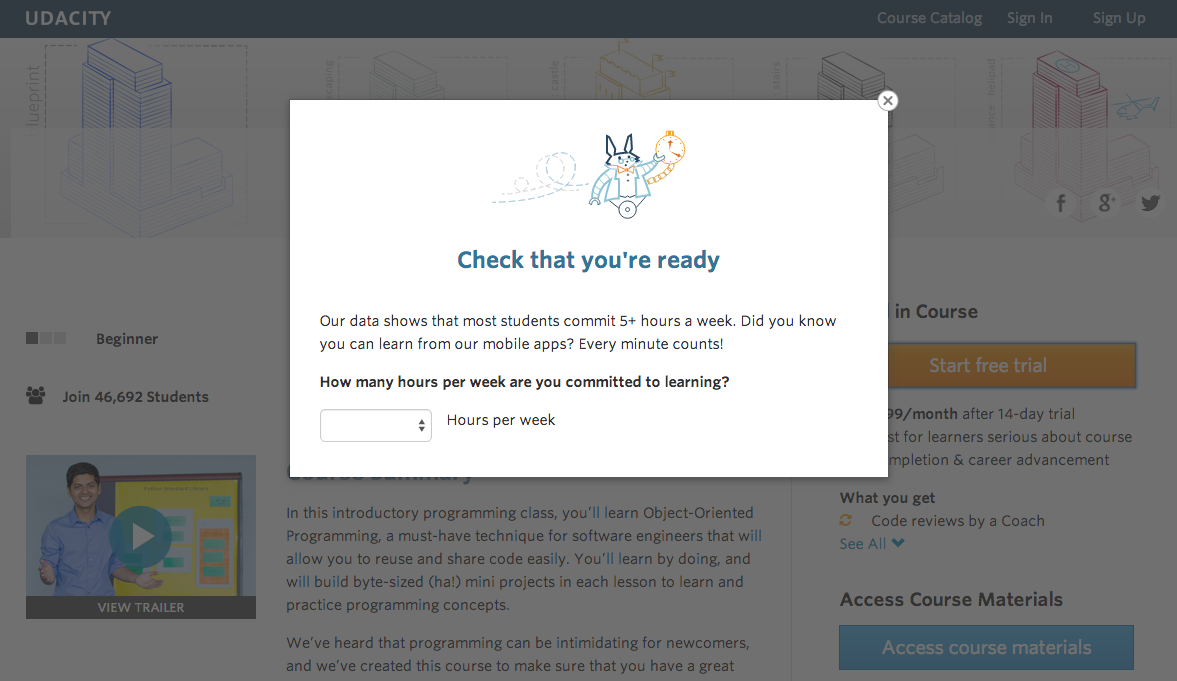

In [2]:
from IPython.display import Image
Image('Final Project Experiment Screenshot.png')

#### Experiment hypothesis

The hypothesis was that this might set clearer expectations for students upfront, thus reducing the number of frustrated students who left the free trial because they didn't have enough time—without significantly reducing the number of students to continue past the free trial and eventually complete the course. If this hypothesis held true, Udacity could improve the overall student experience and improve coaches' capacity to support students who are likely to complete the course.

#### Experiment details

The unit of diversion is a cookie, although if the student enrolls in the free trial, they are tracked by user-id from that point forward. The same user-id cannot enroll in the free trial twice. For users that do not enroll, their user-id is not tracked in the experiment, even if they were signed in when they visited the course overview page.

## 2. Metric Choice

Which of the following metrics would you choose to measure for this experiment and why? For each metric you choose, indicate whether you would use it as an invariant metric or an evaluation metric. The practical significance boundary for each metric, that is, the difference that would have to be observed before that was a meaningful change for the business, is given in parentheses. All practical significance boundaries are given as absolute changes.

Any place "unique cookies" are mentioned, the uniqueness is determined by day. (That is, the same cookie visiting on different days would be counted twice.) User-ids are automatically unique since the site does not allow the same user-id to enroll twice.

We need two types of metrics for a successful experiment (or at least, a safe one); Invariate and evaluation metrics. 

Invariate metrics are used for "sanity checks", that is, to make sure our experiment (the way we presented a change to a part of the population, as well as the way we collected the data) is not inherently wrong. Basically, this means we pick metrics which we consider not to change (not to be affected) because of our experiment and later make sure these metrics don't change drastically between our control and experiment groups.

Evaluation metrics on the other hand, are the metrics in which we expect to see a change, and are relevant to the business goals we aim to achieve. For each metric we state a D_min - which marks the minimum change which is practically significant to the business. For instance, stating that any increase in retention that is under 2%, even if statistically significant, is not practical to the business.

####  Invariate Metrics - Sanity Checks

| Metric Name | Metric Formula | D_min | Notation  |
|------|------|------|------|
|Number of Cookies in Course Overview Page|# unique daily cookies on page|3000 cookies|$C_k$|
|Number of Clicks on Free Trial Button| # unique daily cookies who clicked| 240 clicks|$C_l$|
|Free Trial button Click-Through-Probability|$\frac{C_l}{C_k}$|0.01|CTP|




#### Evaluation Metrics - Performance Indicators 

| Metric Name | Metric Formula | D_min | Notation |
|--------|------|------|------|
|Gross Conversion|$\frac{Enrolled}{C_l}$|0.01|$Conversion_{Gross}$|
|Retention|$\frac{Paid}{Enrolled}$| 0.01|Retention|
|Net Conversion|$\frac{Paid}{C_l}$|0.0075|Conversion_{Net}|


You should also decide now what results you will be looking for in order to launch the experiment. Would a change in any one of your evaluation metrics be sufficient? Would you want to see multiple metrics all move or not move at the same time in order to launch? This decision will inform your choices while designing the experiment.



#### Goal of experiment

1. Reduce number of students who left trail
2. No significant decrease in number of students past trail -> enrol

That is

1. Increase net conversion
2. Increase Retention
3. 

Note: An important remark: the number of user-ids is neither a good invariant metric nor a good evaluation metric.

From one side, the new pop-up message is likely to decrease the total number of user-ids who enrolled in the free trial, so it is not invariant; from the other side it is not normalized, the number of visitors may be different between the experiment and control groups, so it is not good for evaluation.

## 3. Measuring Variability

Estimates of the baseline values for these metrics:

|  Item | Description | Estimator |
|------|------|------|
|Number of Cookies|Daily unique cookies to view course overview page| 	40,000|
|Number of Clicks| Daily unique cookies to click Free Trial button| 3,200|
|Number of enrollments|Free Trial enrollments per day|660|
|CTP|CTP on Free Trial button|0.08|
|Gross Conversion| Probability of enrolling, given a click| 0.20625|
|Retention|Probability of payment, given enrollment|0.53|
|Net Conversion|Probability of payment, given click|0.109313|

In [3]:
#Let's place this estimators into a dictionary for ease of use later
baseline = {"Cookies":40000,"Clicks":3200,"Enrollments":660,"CTP":0.08,"GConversion":0.20625,
           "Retention":0.53,"NConversion":0.109313}

For each metric you selected as an evaluation metric, estimate its standard deviation analytically. Do you expect the analytic estimates to be accurate? That is, for which metrics, if any, would you want to collect an empirical estimate of the variability if you had time?

Once we collected these estimates, we should estimate the standard deviation of a metric, this is computed for sample size calculations and confidence intervals for our results. The more variant a metric is, the harder it is to reach a significant result. Assuming a sample size of 5,000 cookies visiting the course overview page per day (as given in project's instructions) - we want to estimate a standard deviation, for the evaluation metrics only. The sample size we are considering should be smaller than the "population" we collected and small enough to have two groups with that size.

In [4]:
#Scale The counts estimates
baseline["Cookies"] = 5000
baseline["Clicks"]=baseline["Clicks"]*(5000/40000)
baseline["Enrollments"]=baseline["Enrollments"]*(5000/40000)
baseline

{'Cookies': 5000,
 'Clicks': 400.0,
 'Enrollments': 82.5,
 'CTP': 0.08,
 'GConversion': 0.20625,
 'Retention': 0.53,
 'NConversion': 0.109313}

#### Estimating Analytically

In order to estimate variance analytically, we can assume metrics which are probabilities (p^) are binomially distributed, so we can use this formula for the standard deviation: 

$$ SD = \sqrt{\frac{\widehat{p}*(1-\widehat{p})}{n}}$$

This assumption is only valid when the unit of diversion of the experiment is equal to the unit of analysis (the denominator of the metric formula). In the cases when this is not valid, the actual variance might be different and it is recommended to estimate it empirically.

For each metric, we need to plug two variables into the formula:

$\widehat{p}$ - baseline probability of the event to occur

$n$ - sample size 


Gross Conversion - The baseline probability for Gross Conversion can be calculated by the number of users to enroll in a free trial divided by the number of cookies clicking the free trial. In other words, the probability of enrollment given a click. In this case, the unit of diversion (Cookies), that is the element by which we differentiate samples and assign them to control and experiment groups, is equall to the unit of analysis (cookies who click), that is the denominator of the formula to calculate Gross Conversion (GC). When this is the case, this analytic estimate of variance is sufficient.

In [7]:
# Let's get the p and n we need for Gross Conversion (GC)
# and compute the Stansard Deviation(sd) rounded to 4 decimal digits.
GC={}
GC["d_min"]=0.01
GC["p"]=baseline["GConversion"]
#p is given in this case - or we could calculate it from enrollments/clicks
GC["n"]=baseline["Clicks"]
GC["sd"]=round(mt.sqrt((GC["p"]*(1-GC["p"]))/GC["n"]),4)
GC["sd"]

0.0202

Retention - The baseline probability for retention is the number of paying users (enrolled after 14 free days) divided by the number of total enrolled users. In other words, the probability of payment, given enrollment. The sample size is the number of enrolled users. In this case, unit of diversion is not equal to unit of analysis (users who enrolled) so an analytical estimation is not enough - if we had the data for these estimates, we would want to estimate this variance empirically as well.

In [8]:
# Let's get the p and n we need for Retention(R)
# and compute the Stansard Deviation(sd) rounded to 4 decimal digits.
R={}
R["d_min"]=0.01
R["p"]=baseline["Retention"]
R["n"]=baseline["Enrollments"]
R["sd"]=round(mt.sqrt((R["p"]*(1-R["p"]))/R["n"]),4)
R["sd"]

0.0549

Net Conversion - The baseline probability for the net conversion is the number of paying users divided by the number of cookies that clicked the free trial button. In other words, the probability of payment, given a click. The sample size is the number of cookies that clicked. In this case, the unit of analysis and diversion are equal so we expect a good enough estimation analytically.

In [9]:
# Let's get the p and n we need for Net Conversion (NC)
# and compute the Standard Deviation (sd) rounded to 4 decimal digits.
NC={}
NC["d_min"]=0.0075
NC["p"]=baseline["NConversion"]
NC["n"]=baseline["Clicks"]
NC["sd"]=round(mt.sqrt((NC["p"]*(1-NC["p"]))/NC["n"]),4)
NC["sd"]

0.0156

## 4. Sizing

### Number of Samples vs. Power

Using the analytic estimates of variance, how many pageviews total (across both groups) would you need to collect to adequately power the experiment? Use an alpha of 0.05 and a beta of 0.2. Make sure you have enough power for each metric.

Online calculator: https://www.evanmiller.org/ab-testing/sample-size.html

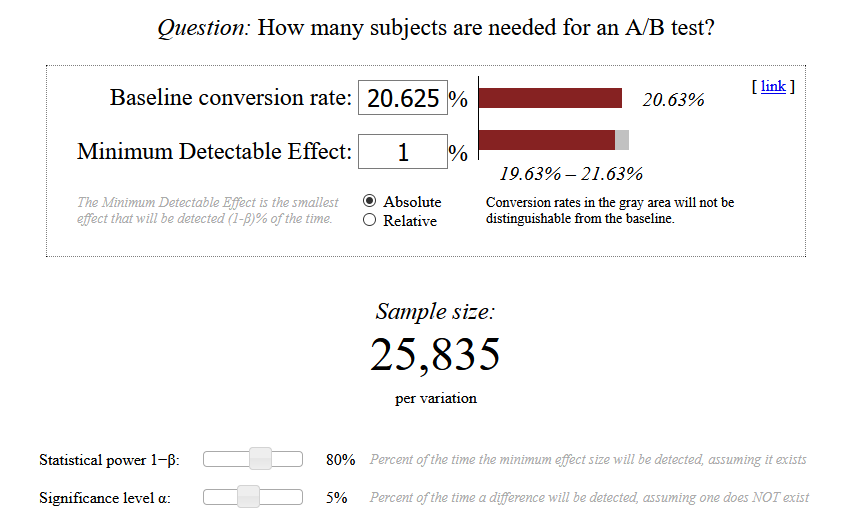

In [11]:
Image('Gross conversion.PNG')

This means we need at least 25,835 cookies who click the Free Trial button - per group.

From the scaled data, we get 400 clicks out of 5000 pageviews (0.08). Therefore, need 25835/0.08 = 322,938 pageviews per group.

So total = 322938*2 = 645875

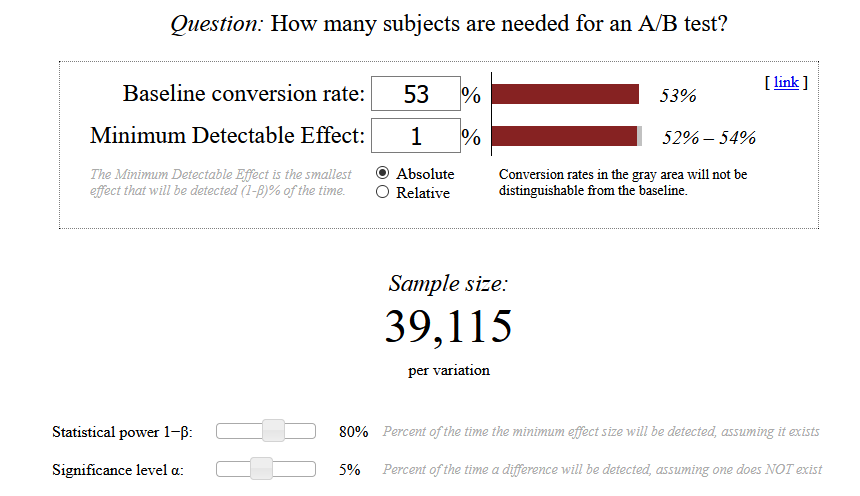

In [12]:
Image('Retention.PNG')

This means that we need 39,115 users who enrolled per group.

We have to first convert this to cookies who clicked, and then to cookies who viewed the page, then finally to multipky by two for both groups.

39115/0.08/0.20625 *2 = 4741212.12

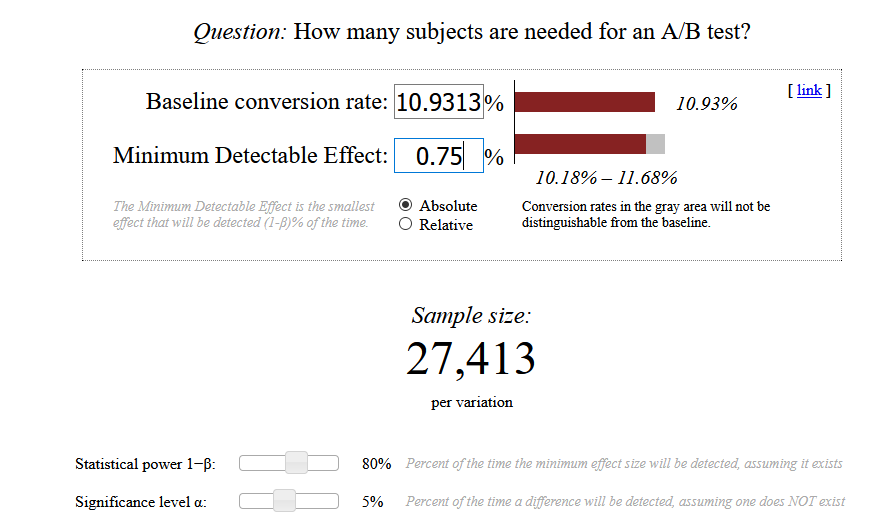

In [13]:
Image('Net conversion.PNG')

So, needing 27,413 cookies who click per group 

Total = 2*27413/2 = 685325

### Duration vs. Exposure

Indicate what fraction of traffic you would divert to this experiment and, given this, how many days you would need to run the experiment. (These should be the answers from the "Choosing Duration and Exposure" quiz.)


## Experiment Analysis
This data contains the raw information needed to compute the above metrics, broken down day by day. Note that there are two sheets within the spreadsheet - one for the experiment group, and one for the control group.

The meaning of each column is:

    Pageviews: Number of unique cookies to view the course overview page that day.
    Clicks: Number of unique cookies to click the course overview page that day.
    Enrollments: Number of user-ids to enroll in the free trial that day.
    Payments: Number of user-ids who who enrolled on that day to remain enrolled for 14 days and thus make a payment. 
    
(Note that the date for this column is the start date, that is, the date of enrollment, rather than the date of the payment. The payment happened 14 days later. Because of this, the enrollments and payments are tracked for 14 fewer days than the other columns.)
    
    

### Load data


In [19]:
control_data = pd.read_csv('Final Project Results - Control.csv')
experiment_data = pd.read_csv('Final Project Results - Experiment.csv')
control_data.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


 The given spreadsheet lists pageviews and clicks for 39 days, while it only lists enrollments and payments for 23 days. 

In [22]:
control_data2 = control_data[:23]
experiment_data2 = experiment_data[:23]

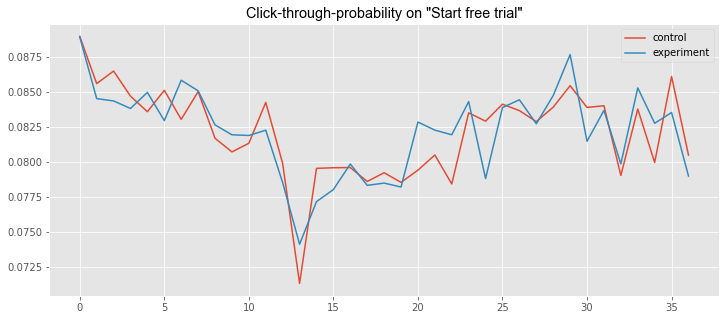

In [23]:
# Plot the metrics
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 5)
csfont = {'fontname':'Arial'}
plt.title('Click-through-probability on "Start free trial"', **csfont)
line1, = plt.plot(control_data['Clicks']/control_data['Pageviews'], label='control')
line2, = plt.plot(experiment_data['Clicks']/experiment_data['Pageviews'], label='experiment')
plt.legend(handles=[line1, line2])

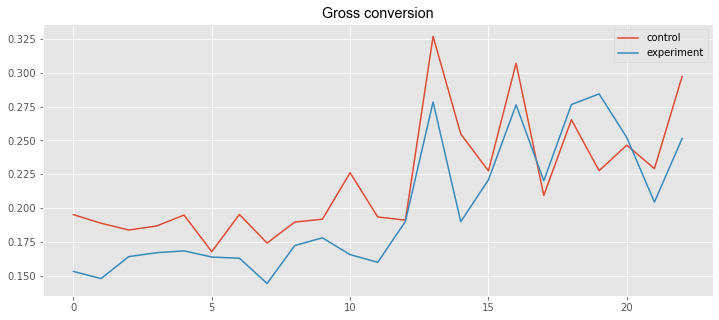

In [24]:
plt.title('Gross conversion', **csfont)
line3, = plt.plot(control_data2['Enrollments']/control_data2['Clicks'], label='control')
line4, = plt.plot(experiment_data2['Enrollments']/experiment_data2['Clicks'], label='experiment')
plt.legend(handles=[line3, line4])

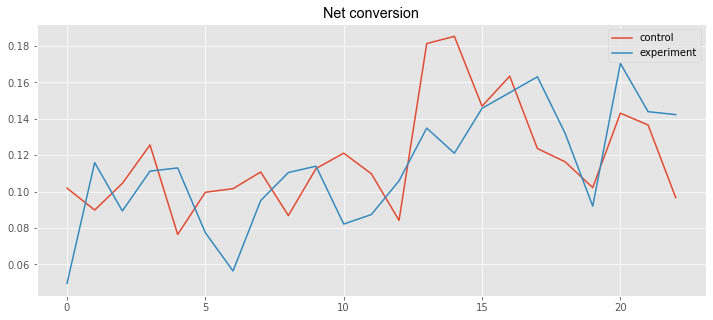

In [25]:
plt.title('Net conversion', **csfont)
line7, = plt.plot(control_data2['Payments']/control_data2['Clicks'], label='control')
line8, = plt.plot(experiment_data2['Payments']/experiment_data2['Clicks'], label='experiment')
plt.legend(handles=[line7, line8])

### Sanity Checks

For each of your invariant metrics, give the 95% confidence interval for the value you expect to observe, the actual observed value, and whether the metric passes your sanity check. 

For any sanity check that did not pass, explain your best guess as to what went wrong based on the day-by-day data. Do not proceed to the rest of the analysis unless all sanity checks pass.



We have 3 Invariant metrics::

    Number of Cookies in Course Overview Page
    Number of Clicks on Free Trial Button
    Free Trial button Click-Through-Probability

Two of these metrics are simple counts like number of cookies or number of clicks and the third is a probability (CTP). We will use two different ways of checking whether these obsereved values are like we expect (if in fact the experiment was not damaged.

#### Sanity Checks for differences between counts

1. Number of cookies who viewed the course overview page - Starting from this simpel invariant metric, we want to count the total amount of cookie pageviews we diverted to each group and see if there is a significant difference int he amount of cookies. A significant difference will imply a biased experiment that we should not rely on it's results.

In [26]:
pageviews_cont=control_data['Pageviews'].sum()
pageviews_exp=experiment_data['Pageviews'].sum()
pageviews_total=pageviews_cont+pageviews_exp
print ("number of pageviews in control:", pageviews_cont)
print ("number of Pageviewsin experiment:" ,pageviews_exp)

number of pageviews in control: 345543
number of Pageviewsin experiment: 344660


let's make sure this difference in amounts is not significant and is random and even like we expected. We can model this diversion in the following way:

We expect the amount of pageviews in the control group to be about a half (50%) of the total pageviews in both groups, so we can define a random variable with an easy to use distribution.

A binomial random variable will be the number of successes we can expect to get out of N experiments, given the probability of a single success. So, if we consider being assigned to a group (control, for example) a success with probability 0.5 (random!), the number of samples which get assigned to the group is the value of our random binomial variable! 

This get's easier thanks to the central limit theorem which let's us approximate the binomial distribution to a normal distribution (when n is large enough) with a mean of p and a standard deviation $\sqrt{\frac{p(1-p)}{N}}$

$$X ~ N( p,\sqrt{\frac{p(1-p)}{N}})$$

What we want to test is whether our observed p^ (number of samples in control divided by total number of damples in both groups) is not significantly different than p=0.5. In order to do that we can calculate the margin of error acceptable at a 95% confidence level:
$$ME=Z_{1-\frac{\alpha}{2}}SD$$

Finally, a confidence interval can be derived to tell us in which range an observed p can exist and be acceptable as "the same" as the expected value.

$$CI=[\hat{p}-ME,\hat{p}+ME]$$

If p is in the interval, test passed.

In [28]:
def get_z_score(alpha):
    return norm.ppf(alpha)

In [29]:
p=0.5
alpha=0.05
p_hat=round(pageviews_cont/(pageviews_total),4)
sd=mt.sqrt(p*(1-p)/(pageviews_total))
ME=round(get_z_score(1-(alpha/2))*sd,4)
print ("The confidence interval is between",p-ME,"and",p+ME,"; Is",p_hat,"inside this range?")

The confidence interval is between 0.4988 and 0.5012 ; Is 0.5006 inside this range?


2. Number of cookies who clicked the Free Trial Button We are going to address this count with the same strategy as before.

In [31]:
clicks_cont=control_data['Clicks'].sum()
clicks_exp=experiment_data['Clicks'].sum()
clicks_total=clicks_cont+clicks_exp

p_hat=round(clicks_cont/clicks_total,4)
sd=mt.sqrt(p*(1-p)/clicks_total)
ME=round(get_z_score(1-(alpha/2))*sd,4)
print ("The confidence interval is between",p-ME,"and",p+ME,"; Is",p_hat,"inside this range?")

The confidence interval is between 0.4959 and 0.5041 ; Is 0.5005 inside this range?


#### Sanity Checks for differences between probabilities ¶

Click-through-probability of the Free Trial Button In this case, we want to make sure the proportion of clicks given a pageview (our observed CTP) is about the same in both groups (since this was not expected to change due to the experiment). In order to check this out we will calculate the CTP in each group and calculate a confidence interval for the expected difference between them. 

In other words, we expect to see no difference (CTPexp−CTPcont=0), with an acceptable margin of error, dictated by our calculated confidence interval. The changes we should notice are for the calculation of the standard error - which in this case is a pooled standard error.

$$SD_{pool}=\sqrt{\hat{p_{pool}}(1-\hat{p_{pool}}(\frac{1}{N_{cont}}+\frac{1}{N_{exp}})}$$
with
$$\hat{p_{pool}}=\frac{x_{cont}+x_{exp}}{N_{cont}+N_{exp}}$$

In [32]:
ctp_cont=clicks_cont/pageviews_cont
ctp_exp=clicks_exp/pageviews_exp
d_hat=round(ctp_exp-ctp_cont,4)
p_pooled=clicks_total/pageviews_total
sd_pooled=mt.sqrt(p_pooled*(1-p_pooled)*(1/pageviews_cont+1/pageviews_exp))
ME=round(get_z_score(1-(alpha/2))*sd_pooled,4)
print ("The confidence interval is between",0-ME,"and",0+ME,"; Is",d_hat,"within this range?")

The confidence interval is between -0.0013 and 0.0013 ; Is 0.0001 within this range?


## Result Analysis

### Effect Size Tests

For each of your evaluation metrics, give a 95% confidence interval around the difference between the experiment and control groups. Indicate whether each metric is statistically and practically significant. (These should be the answers from the "Effect Size Tests" quiz.)

The next step is looking at the changes between the control and experiment groups with regard to our evaluation metrics to make sure the difference is there, that it is statistically significant and most importantly practically significant (the difference is "big" enough to make the experimented change beneficial to the company).

Now, all that is left is to measure for each evaluation metric, the difference between the values from both groups. Then, we compute the confidence interval for that difference and test whether or not this confidence interval is both statistically and practically significant.

Gross Conversion A metric is statistically significant if the confidence interval does not include 0 (that is, you can be confident there was a change), and it is practically significant if the confidence interval does not include the practical significance boundary (that is, you can be confident there is a change that matters to the business.)

In [33]:
# Count the total clicks from complete records only
clicks_cont=control_data["Clicks"].loc[control_data["Enrollments"].notnull()].sum()
clicks_exp=experiment_data["Clicks"].loc[experiment_data["Enrollments"].notnull()].sum()

In [34]:
#Gross Conversion - number of enrollments divided by number of clicks
enrollments_cont=control_data["Enrollments"].sum()
enrollments_exp=experiment_data["Enrollments"].sum()

GC_cont=enrollments_cont/clicks_cont
GC_exp=enrollments_exp/clicks_exp
GC_pooled=(enrollments_cont+enrollments_exp)/(clicks_cont+clicks_exp)
GC_sd_pooled=mt.sqrt(GC_pooled*(1-GC_pooled)*(1/clicks_cont+1/clicks_exp))
GC_ME=round(get_z_score(1-alpha/2)*GC_sd_pooled,4)
GC_diff=round(GC_exp-GC_cont,4)
print("The change due to the experiment is",GC_diff*100,"%")
print("Confidence Interval: [",GC_diff-GC_ME,",",GC_diff+GC_ME,"]")
print ("The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if",-GC["d_min"],"is not in the CI as well.")

The change due to the experiment is -2.06 %
Confidence Interval: [ -0.0292 , -0.012 ]
The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if -0.01 is not in the CI as well.


According to this result there was a change due to the experiment, that change was both statistically and practically significant. We have a negative change of 2.06%, when we were willing to accept any change greater than 1%. This means the Gross Conversion rate of the experiment group (the one exposed to the change, i.e. asked how many hours they can devote to studying) has decreased as expected by 2% and this change was significant. This means less people enrolled in the Free Trial after due to the pop-up.

Net Conversion The hypothesis is the same as before just with net conversion instead of gross. At this point we expect the fraction of payers (out of the clicks) to decrease as well.

In [35]:
#Net Conversion - number of payments divided by number of clicks
payments_cont=control_data["Payments"].sum()
payments_exp=experiment_data["Payments"].sum()

NC_cont=payments_cont/clicks_cont
NC_exp=payments_exp/clicks_exp
NC_pooled=(payments_cont+payments_exp)/(clicks_cont+clicks_exp)
NC_sd_pooled=mt.sqrt(NC_pooled*(1-NC_pooled)*(1/clicks_cont+1/clicks_exp))
NC_ME=round(get_z_score(1-alpha/2)*NC_sd_pooled,4)
NC_diff=round(NC_exp-NC_cont,4)
print("The change due to the experiment is",NC_diff*100,"%")
print("Confidence Interval: [",NC_diff-NC_ME,",",NC_diff+NC_ME,"]")
print ("The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if",NC["d_min"],"is not in the CI as well.")

The change due to the experiment is -0.49 %
Confidence Interval: [ -0.0116 , 0.0018000000000000004 ]
The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if 0.0075 is not in the CI as well.




In this case we got a change size of less than a 0.5%, a very small decrease which is not statistically significant, and as such not practically significant.

### Sign Tests

For each of your evaluation metrics, do a sign test using the day-by-day data, and report the p-value of the sign test and whether the result is statistically significant. (These should be the answers from the "Sign Tests" quiz.)

In a sign test we get another angle at analyzing the results we got - we check if the trend of change we observed (increase or decrease) was evident in the daily data. We are goint to compute the metric's value per day and then count on how many days the metric was lower in the experiment group and this will be the number of succssesses for our binomial variable. Once this is defined we can look at the proportion of days of success out of all the available days.

#### 1. Data preparation

In [36]:
#let's first create the dataset we need for this:
# start by merging the two datasets
full=control_data.join(other=experiment_data,how="inner",lsuffix="_cont",rsuffix="_exp")
#Let's look at what we got
full.count()

Date_cont           37
Pageviews_cont      37
Clicks_cont         37
Enrollments_cont    23
Payments_cont       23
Date_exp            37
Pageviews_exp       37
Clicks_exp          37
Enrollments_exp     23
Payments_exp        23
dtype: int64

In [37]:
#now we only need the complete data records
full=full.loc[full["Enrollments_cont"].notnull()]
full.count()

Date_cont           23
Pageviews_cont      23
Clicks_cont         23
Enrollments_cont    23
Payments_cont       23
Date_exp            23
Pageviews_exp       23
Clicks_exp          23
Enrollments_exp     23
Payments_exp        23
dtype: int64

In [38]:
# Now, derive a new column for each metric, so we have it's daily values
# We need a 1 if the experiment value is greater than the control value=
x=full['Enrollments_cont']/full['Clicks_cont']
y=full['Enrollments_exp']/full['Clicks_exp']
full['GC'] = np.where(x<y,1,0)
# The same now for net conversion
z=full['Payments_cont']/full['Clicks_cont']
w=full['Payments_exp']/full['Clicks_exp']
full['NC'] = np.where(z<w,1,0)
full.head()

,Date_cont,Pageviews_cont,Clicks_cont,Enrollments_cont,Payments_cont,Date_exp,Pageviews_exp,Clicks_exp,Enrollments_exp,Payments_exp,GC,NC
0,"Sat, Oct 11",7723,687,134.0,70.0,"Sat, Oct 11",7716,686,105.0,34.0,0,0
1,"Sun, Oct 12",9102,779,147.0,70.0,"Sun, Oct 12",9288,785,116.0,91.0,0,1
2,"Mon, Oct 13",10511,909,167.0,95.0,"Mon, Oct 13",10480,884,145.0,79.0,0,0
3,"Tue, Oct 14",9871,836,156.0,105.0,"Tue, Oct 14",9867,827,138.0,92.0,0,0
4,"Wed, Oct 15",10014,837,163.0,64.0,"Wed, Oct 15",9793,832,140.0,94.0,0,1


In [39]:
GC_x=full.GC[full["GC"]==1].count()
NC_x=full.NC[full["NC"]==1].count()
n=full.NC.count()
print("No. of cases for GC:",GC_x,'\n',
      "No. of cases for NC:",NC_x,'\n',
      "No. of total cases",n)

No. of cases for GC: 4 
 No. of cases for NC: 10 
 No. of total cases 23


#### 2. Building a Sign Test

Online calculator: https://www.graphpad.com/quickcalcs/binomial1/

What we want to do after we count the amount of days in which the experiment group had a higher metric value than that of the control group, is to see if that number is likely to be seen again in a new experiment (significance). We assume the chance of a day like this is random (50% chance to happen) and then use the binomial distribution with p=0.5 and the number of experiments (days) to tell us the probability of this happening according to a random chance.

So, according to the binomial distribution with p=0.5 and n=total number of days; we want to now the probability of x days being a success (higher metric value in experiment). Because we are doing a two-tailed test we want to double this probability and once we have we can call it the p−value and compare it to our α. If the p−value is greater than the α the result is not significant and vice-versa.

$$p(successes )=\frac{n!}{x!(n-x)!}p^x(1-p)^{n-x}$$

Recall that a p−value is the probability of observing a test statistic as or more extreme than that observed. If we observed 2 days like that, the p−value for the test is: p−value=P(x<=2). We only need to remember the following:

$$P(x<=2)=P(0)+P(1)+P(2)$$

More information: https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_nonparametric/BS704_Nonparametric5.html

In [40]:
#first a function for calculating probability of x=number of successes
def get_prob(x,n):
    p=round(mt.factorial(n)/(mt.factorial(x)*mt.factorial(n-x))*0.5**x*0.5**(n-x),4)
    return p
#next a function to compute the pvalue from probabilities of maximum x
def get_2side_pvalue(x,n):
    p=0
    for i in range(0,x+1):
        p=p+get_prob(i,n)
    return 2*p



Finally, to conduct the sign test itself: we will calculate the p-value for each metric, using the counts GC_x,NC_x and n and the function get_2side_pvalue.


In [41]:
print ("GC Change is significant if",get_2side_pvalue(GC_x,n),"is smaller than 0.05")
print ("NC Change is significant if",get_2side_pvalue(NC_x,n),"is smaller than 0.05")

GC Change is significant if 0.0026000000000000003 is smaller than 0.05
NC Change is significant if 0.6774 is smaller than 0.05


We get the same conclusions as we got from our effect size calculation: the change in Gross conversion was indeed significant, while the change in Net conversion was not.

## Recommendation
Make a recommendation and briefly describe your reasoning.


We can see that the actual underlying goal we had was not reached (increase fraction of paying users by asking them in advance if they have the time to invest in the course), we can only recommend to not continue with change. It may have caused a change in Gross conversion, but it didn't for net conversion.

Follow-Up Experiment
Give a high-level description of the follow up experiment you would run, what your hypothesis would be, what metrics you would want to measure, what your unit of diversion would be, and your reasoning for these choices.
